# Simple Data Cleaning and EDA on Brazil E-commerce Dataset


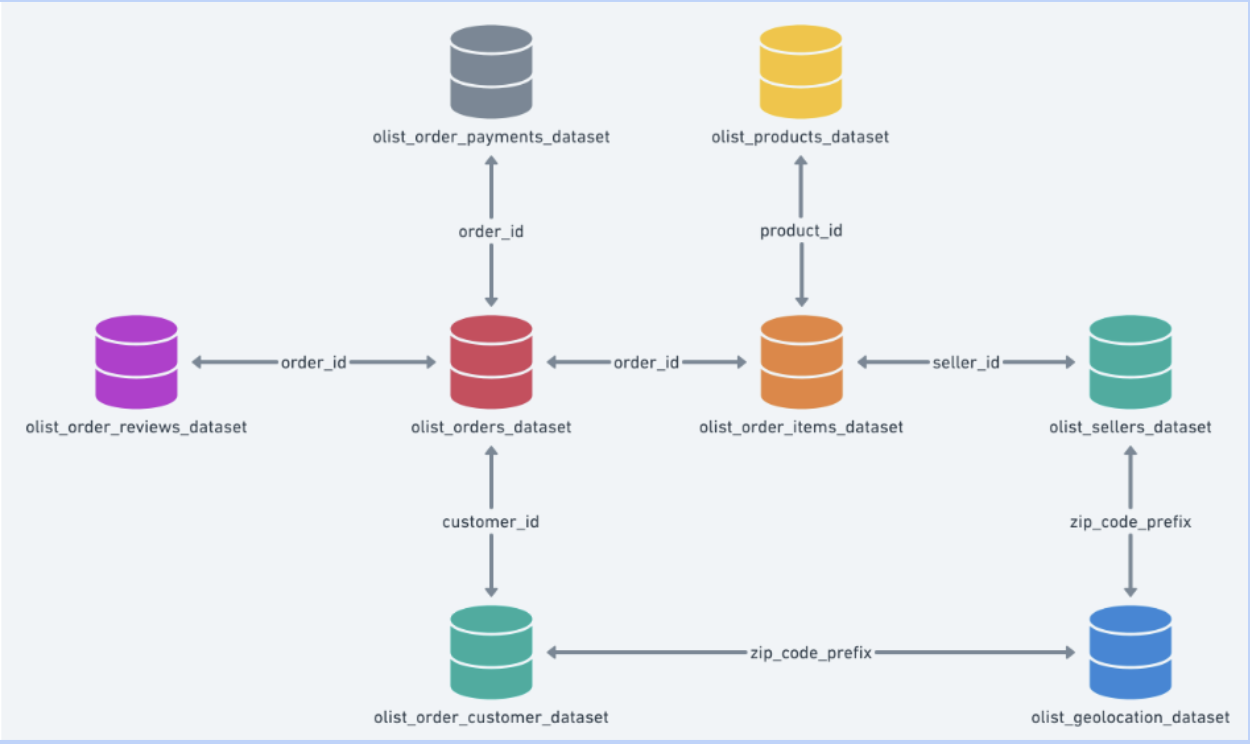


## Objectives

- Search for Top 10 Products that are most in demand
- Look for trends from the Top 10 products that are most in demand
- Look for trends of the price from the Top 10 products that are most in demand


## 0. Preparation


- import data


In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

- connect to DB


In [2]:
con = sqlite3.connect("olist.db")

In [3]:
cur = con.cursor()

- look for tables in db


In [4]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table'")
cur.fetchall()

[('olist_order_customer_dataset',),
 ('olist_order_dataset',),
 ('olist_order_reviews_dataset',),
 ('olist_order_payments_dataset',),
 ('olist_order_items_dataset',),
 ('olist_products_dataset',),
 ('olist_sellers_dataset',),
 ('olist_geolocation_dataset',),
 ('product_category_name_translation',)]

## 1. Objective 1: Search for Top 10 Products that are most in Demand


- take a look at products table


In [5]:
products_df = pd.read_sql_query("SELECT * FROM olist_products_dataset", con)
products_df.head()

,index,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


- take a look at order items table


In [6]:
order_items_df = pd.read_sql_query(
    "SELECT * FROM olist_order_items_dataset", con
)
order_items_df.head()

,index,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


- merge product table and order items table then include only necessary features


In [7]:
products_and_order_items_df = pd.read_sql_query(
    "SELECT product_category_name, order_id FROM olist_products_dataset LEFT JOIN olist_order_items_dataset USING (product_id)",
    con,
)
products_and_order_items_df.head()

,product_category_name,order_id
0,perfumaria,e17e4f88e31525f7deef66779844ddce
1,artes,5236307716393b7114b53ee991f36956
2,esporte_lazer,01f66e58769f84129811d43eefd187fb
3,bebes,143d00a4f2dde4e0364ee1821577adb3
4,utilidades_domesticas,86cafb8794cb99a9b1b77fc8e48fbbbb


- check missing values


In [8]:
products_and_order_items_df.isna().sum() / len(products_and_order_items_df)

product_category_name    0.01423
order_id                 0.00000
dtype: float64

- since `product_category_name` is object data, fill its missing values with string "unknown"


In [9]:
products_and_order_items_df[
    "product_category_name"
] = products_and_order_items_df["product_category_name"].fillna("unknown")

- check if it fills all missing values


In [10]:
products_and_order_items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 2 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   product_category_name  112650 non-null  object
 1   order_id               112650 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


- it's good, then visualize the top 10 most in demand products


In [11]:
top_10_categories_df = pd.DataFrame(
    products_and_order_items_df.groupby("product_category_name")["order_id"]
    .count()
    .sort_values(ascending=False)
    .head(10)
).reset_index()

top_10_categories_df

,product_category_name,order_id
0,cama_mesa_banho,11115
1,beleza_saude,9670
2,esporte_lazer,8641
3,moveis_decoracao,8334
4,informatica_acessorios,7827
5,utilidades_domesticas,6964
6,relogios_presentes,5991
7,telefonia,4545
8,ferramentas_jardim,4347
9,automotivo,4235


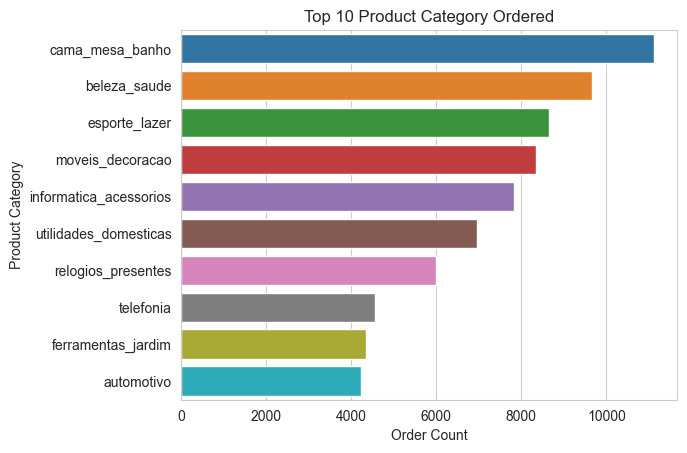

In [12]:
# This function takes the top 10 categories and colors them based on the number of
top_10_categories = top_10_categories_df["product_category_name"].unique()
palette = dict(
    zip(top_10_categories, sns.color_palette(n_colors=len(top_10_categories)))
)

# create the barplot using Seaborn
sns.set_style("whitegrid")
sns.barplot(
    y="product_category_name",
    x="order_id",
    data=top_10_categories_df,
    palette=palette,
)

# set the title and axis labels
plt.title("Top 10 Product Category Ordered")
plt.ylabel("Product Category")
plt.xlabel("Order Count")

# show the plot
plt.show()

**Analysis**

- `cama_mesa_banho`, or "bed table bath" in english, is the most in demand category in Brazil


## 2. Objective 2: Look for trends from the top 10 products that are most in demand


- take a look at order table


In [13]:
orders_df = pd.read_sql_query("SELECT * FROM olist_order_dataset", con)
orders_df.head()

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


- look for first product ordered, it's September 2016


In [14]:
orders_df.sort_values("order_purchase_timestamp").head(1)

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
4541,4541,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,None,2016-10-20 00:00:00


- merge product table, order items table, and order table, then include only necessary features


In [15]:
products_and_order_items_and_orders_df = pd.read_sql_query(
    "SELECT product_category_name, order_id, order_purchase_timestamp, customer_id, price FROM olist_products_dataset LEFT JOIN olist_order_items_dataset USING (product_id) LEFT JOIN olist_order_dataset USING (order_id)",
    con,
)
products_and_order_items_and_orders_df.head()

,product_category_name,order_id,order_purchase_timestamp,customer_id,price
0,perfumaria,e17e4f88e31525f7deef66779844ddce,2018-04-24 16:16:53,f8a3e963a310aa58b60a5b1fed5bceb5,10.91
1,artes,5236307716393b7114b53ee991f36956,2018-01-31 18:55:36,03fc97548af8f58fefc768d12b546c9c,248.00
2,esporte_lazer,01f66e58769f84129811d43eefd187fb,2018-07-09 21:18:01,e41819d1c95c12c9ce495b630eab8aee,79.80
3,bebes,143d00a4f2dde4e0364ee1821577adb3,2018-08-03 08:55:50,322162b5ca010c2b059cb5224dd818b1,112.30
4,utilidades_domesticas,86cafb8794cb99a9b1b77fc8e48fbbbb,2018-04-11 01:06:37,c11c31965ff02cc1d7132df8edfcbc22,37.90


- check missing data


In [16]:
products_and_order_items_and_orders_df.isna().sum() / len(
    products_and_order_items_and_orders_df
)

product_category_name       0.01423
order_id                    0.00000
order_purchase_timestamp    0.00000
customer_id                 0.00000
price                       0.00000
dtype: float64

- it's missing `product_category_name` again, fill the missing values with string "unknown"


In [17]:
products_and_order_items_and_orders_df[
    "product_category_name"
] = products_and_order_items_df["product_category_name"].fillna("unknown")

In [18]:
products_and_order_items_and_orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 5 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   product_category_name     112650 non-null  object 
 1   order_id                  112650 non-null  object 
 2   order_purchase_timestamp  112650 non-null  object 
 3   customer_id               112650 non-null  object 
 4   price                     112650 non-null  float64
dtypes: float64(1), object(4)
memory usage: 4.3+ MB


- it's good then group every top 10 categories by purchased year


In [19]:
products_and_order_items_and_orders_df["year"] = pd.to_datetime(
    products_and_order_items_and_orders_df["order_purchase_timestamp"]
).dt.year

products_and_order_items_and_orders_df.head()

,product_category_name,order_id,order_purchase_timestamp,customer_id,price,year
0,perfumaria,e17e4f88e31525f7deef66779844ddce,2018-04-24 16:16:53,f8a3e963a310aa58b60a5b1fed5bceb5,10.91,2018
1,artes,5236307716393b7114b53ee991f36956,2018-01-31 18:55:36,03fc97548af8f58fefc768d12b546c9c,248.00,2018
2,esporte_lazer,01f66e58769f84129811d43eefd187fb,2018-07-09 21:18:01,e41819d1c95c12c9ce495b630eab8aee,79.80,2018
3,bebes,143d00a4f2dde4e0364ee1821577adb3,2018-08-03 08:55:50,322162b5ca010c2b059cb5224dd818b1,112.30,2018
4,utilidades_domesticas,86cafb8794cb99a9b1b77fc8e48fbbbb,2018-04-11 01:06:37,c11c31965ff02cc1d7132df8edfcbc22,37.90,2018


In [20]:
products_and_order_items_and_orders_only_top_10_categories_df = (
    products_and_order_items_and_orders_df[
        products_and_order_items_and_orders_df["product_category_name"].isin(
            top_10_categories
        )
    ]
)

products_and_order_items_and_orders_only_top_10_categories_df.head()

,product_category_name,order_id,order_purchase_timestamp,customer_id,price,year
2,esporte_lazer,01f66e58769f84129811d43eefd187fb,2018-07-09 21:18:01,e41819d1c95c12c9ce495b630eab8aee,79.80,2018
4,utilidades_domesticas,86cafb8794cb99a9b1b77fc8e48fbbbb,2018-04-11 01:06:37,c11c31965ff02cc1d7132df8edfcbc22,37.90,2018
8,moveis_decoracao,6ecf7023e8dd4ec8b08746c35b9fcb60,2017-11-24 14:22:48,181e2217f874cb5390be37f378db5e07,9.99,2017
9,moveis_decoracao,6ecf7023e8dd4ec8b08746c35b9fcb60,2017-11-24 14:22:48,181e2217f874cb5390be37f378db5e07,9.99,2017
10,moveis_decoracao,8ac5b235603eee2e21e36261b2df536c,2017-11-27 11:26:14,2ea5983ec2edde5dcba726ea64e9fadb,9.99,2017


- check for outliers for every categories, turn out that every categories have outliers


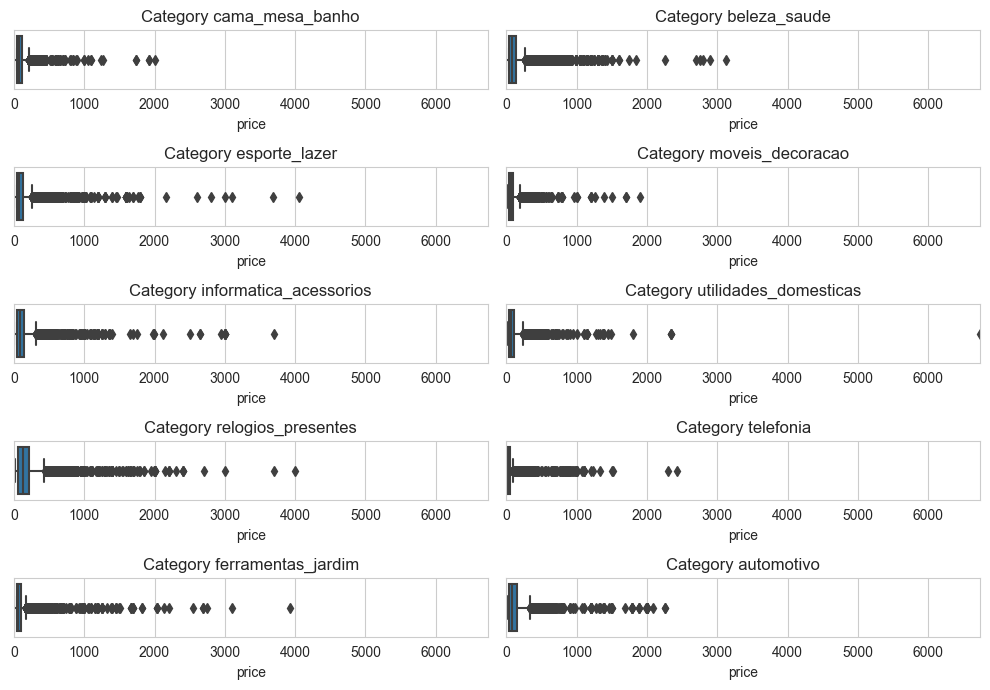

In [21]:
def draw_boxplot(df):
    # Create a multiplot of histplot for each category
    fig, axes = plt.subplots(
        len(top_10_categories) // 2,
        2,
        figsize=(10, 0.7 * len(top_10_categories)),
    )

    for i, category in enumerate(top_10_categories):
        row = i // 2
        col = i % 2
        ax = axes[row, col]
        sns.boxplot(
            data=df[df["product_category_name"] == category],
            x="price",
            ax=ax,
        )
        ax.set_title(f"Category {category}")
        ax.set_xlim([0, df["price"].max()])

    plt.tight_layout()
    plt.show()


draw_boxplot(products_and_order_items_and_orders_only_top_10_categories_df)

- remove outliers using the Tukey method


> It is calculated by creating a “fence” boundary a distance of 1.5 IQR beyond the 1st and 3rd quartiles. Any data beyond these fences are considered to be outliers. for some nonnegative constant k. John Tukey proposed this test, where k = 1.5 indicates an "outlier", and k = 3 indicates data that is "far out".


In [22]:
# Define a function to remove outliers using the Tukey method
def remove_outliers_tukey(group):
    q1 = group["price"].quantile(0.25)
    q3 = group["price"].quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    return group[(group["price"] >= low) & (group["price"] <= high)]


# Group the data by category and apply the Tukey method to remove outliers
cleaned_groups = [
    remove_outliers_tukey(group)
    for name, group in products_and_order_items_and_orders_only_top_10_categories_df.groupby(
        "product_category_name"
    )
]

# Combine the cleaned groups back into a single dataframe
cleaned_df = pd.concat(cleaned_groups)

cleaned_df.head()

,product_category_name,order_id,order_purchase_timestamp,customer_id,price,year
75,automotivo,db5f0d2b31255bbf42582d67727f1588,2017-12-04 21:59:19,aae1194a13036a24c766a265bd81a7a5,115.0,2017
168,automotivo,db0e5ecb705ec6060fb71c1b4fb6cf78,2017-02-16 16:36:34,7a732cece3a1b8b7bc5496dbca556bb5,59.9,2017
193,automotivo,f94765982f45d2bae74c9cbf55d37387,2018-02-13 21:06:34,fc1d80ada6741dcac4c20f6da659fb3e,178.9,2018
257,automotivo,86b61d707f8321f38e7287a638bb2ea2,2018-04-12 08:55:14,49b59734c9b8a0188e69ef708430b381,59.9,2018
258,automotivo,f92ef153ceb4a6db2572cc8f79dff479,2017-08-31 08:55:41,832e0159bea501e0a4b1ff43edae6b4d,29.9,2017


- check the result


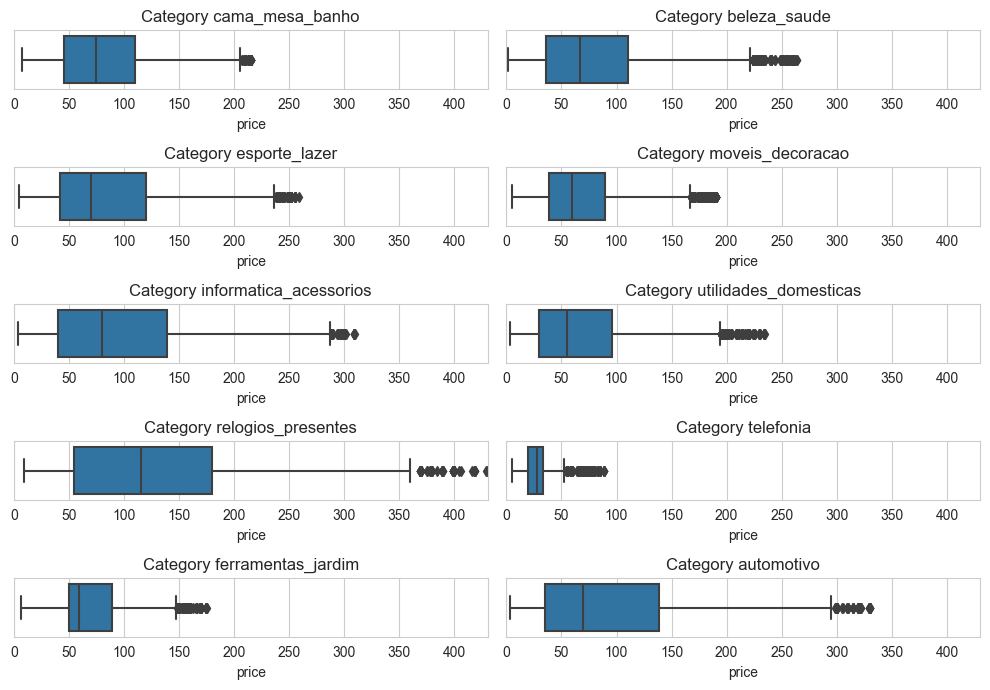

In [23]:
draw_boxplot(cleaned_df)

it's good, then visualize trend of top 10 products


In [32]:
top_10_categories_per_year_df = pd.DataFrame(
    cleaned_df.groupby(["product_category_name", "year"])["order_id"].count()
).reset_index()

top_10_categories_per_year_df.head()

,product_category_name,year,order_id
0,automotivo,2016,11
1,automotivo,2017,1454
2,automotivo,2018,2428
3,beleza_saude,2016,49
4,beleza_saude,2017,3208


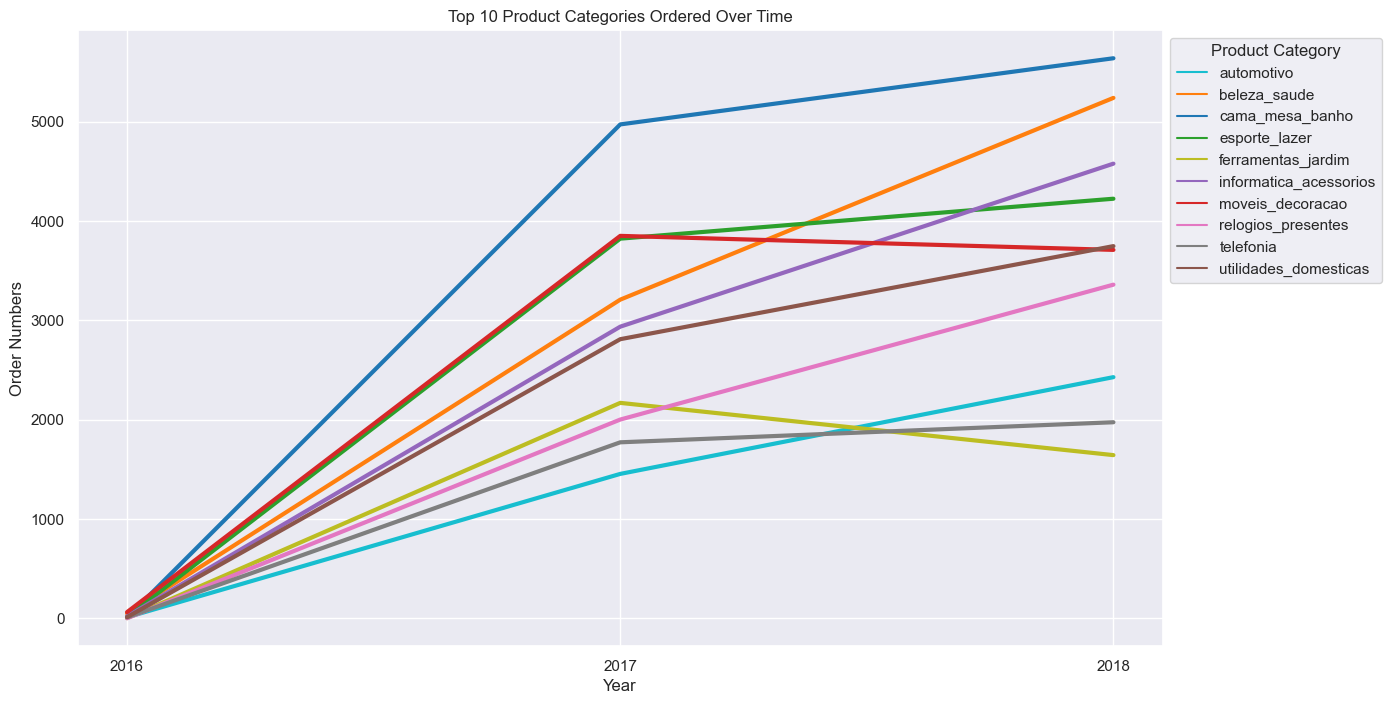

In [33]:
sns.set_style("darkgrid")
sns.set(rc={"figure.figsize": (14, 8)})

ax = sns.lineplot(
    data=top_10_categories_per_year_df,
    x="year",
    y="order_id",
    hue="product_category_name",
    palette=palette,
    legend="full",
    lw=3,
)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.title("Top 10 Product Categories Ordered Over Time")
plt.legend(bbox_to_anchor=(1, 1)).set_title("Product Category")
plt.ylabel("Order Numbers")
plt.xlabel("Year")
plt.show()

**Analysis**

- `cama_mesa_banho` (bed table bath) and `belaza_saude` (beauty health) are categories that reach more than 5000 orders in 2018 and it's increasing since 2016


## Objective 3: Look for trends of the price from the top 10 products that are most in demand


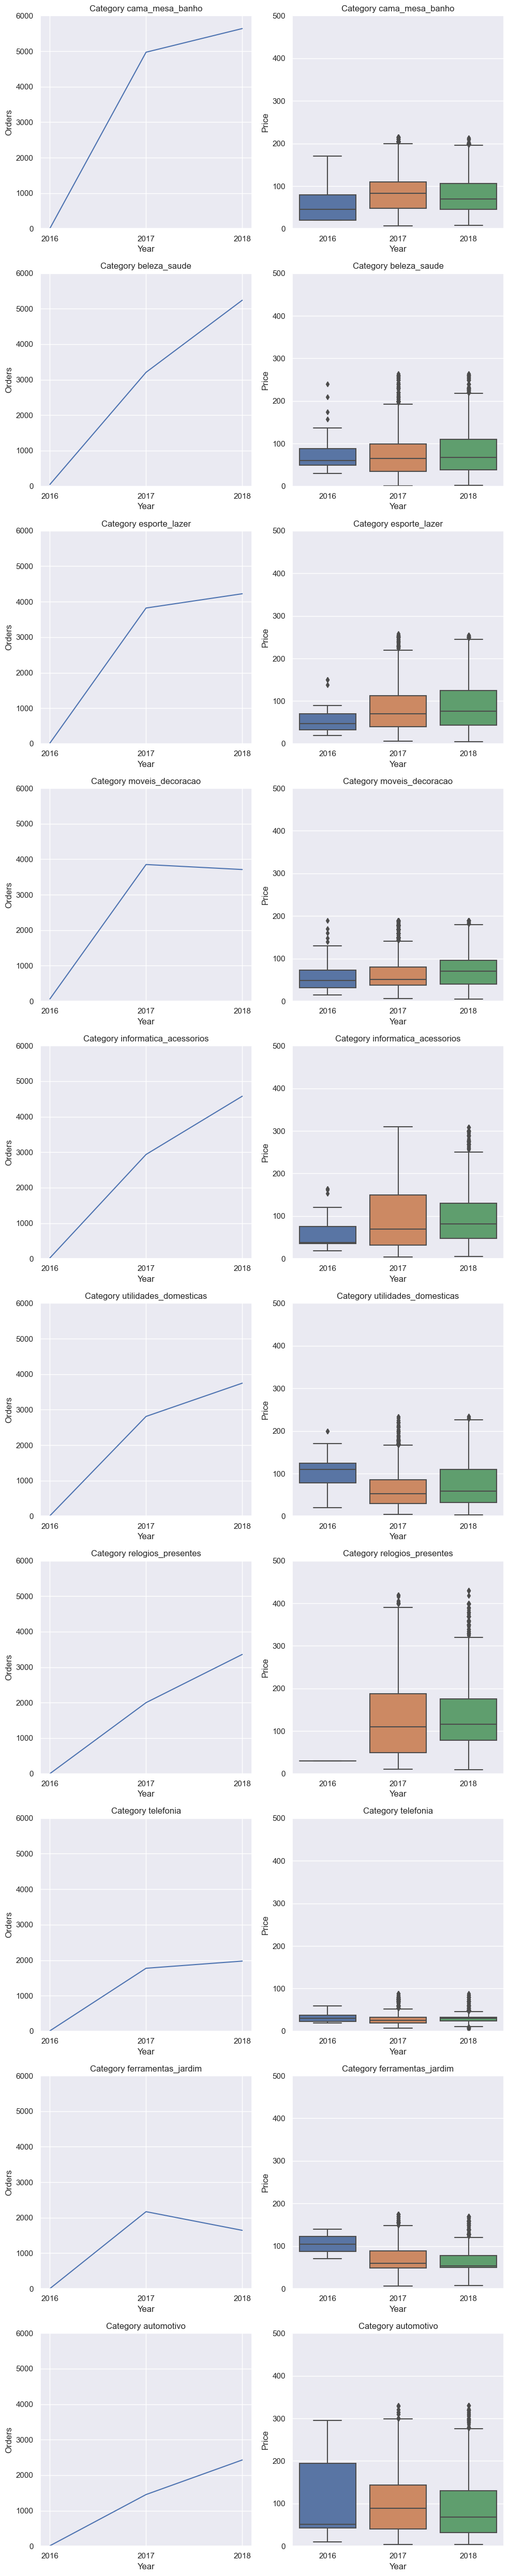

In [31]:
# Create a figure with subplots for each category
num_rows = len(top_10_categories)
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5 * num_rows))

# Plot line plots for VariableA and VariableB in each subplot
for i, category in enumerate(top_10_categories):
    row = i
    col = 0
    ax = axes[row, col]
    sns.lineplot(
        data=top_10_categories_per_year_df,
        y=top_10_categories_per_year_df[
            top_10_categories_per_year_df["product_category_name"] == category
        ]["order_id"],
        x="year",
        ax=ax,
    )
    ax.set_title(f"Category {category}")
    ax.set_xlabel("Year")
    ax.set_ylabel("Orders")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_ylim([0, 6000])

    col = 1
    ax = axes[row, col]
    sns.boxplot(
        data=cleaned_df,
        y=cleaned_df[cleaned_df["product_category_name"] == category]["price"],
        x="year",
        ax=ax,
    )
    ax.set_title(f"Category {category}")
    ax.set_xlabel("Year")
    ax.set_ylabel("Price")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_ylim([0, 500])

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

**Analysis**

- Price of `cama_mesa_benho` (bed table bath) is stagnant despite the increase of orders
- Price of `beleza_saude` (beauty health) is stagnant despite the increase of orders
- Price of `esporte lazer` (sport leisure) is increasing according to the number of orders
- Price of `moveis decoracao` (furniture decoration) is increasing despite the decline of orders
- Price of `informatica accessorios` (computer accessories) is stagnant despite the increase of orders
- Price of `utilidades domesticas` (housewares) is stagnant despite the increase of orders
- Price of `relogios presentes` (gifts watches) is stagnant despite the increase of orders
- Price of `telefonia` (telephony) is stagnant
- Price of `ferramentas jardim` (garden tools) is declining
- Price of `automotivo` (automotive) is declining despite the increase of orders


## Conclussions


1. Consider offering discounts to keep the number of orders increase for `cama_mesa_banho` (bed table bath), `beleza_saude` (beauty health), `esporte_lazer` (sport leisure), `informatica_accessorios` (computer accessories), `utilidades_domesticas` (housewares), `relogios_presentes` (gifts watches),`ferramentas_jardim` (garden tools). Can also boost promotions, give free shipping, give other incentives that related to the product.

2. Consider improving products presentation for `moveis_decoracao` (furniture decoration), `telefonia` (telephony), `automotivo` (automotive) to increase number of orders. Could be by improving product descriptions, images, or highlighting the unique features of each products, or assuring if product is broken.

3. Keep conduct marketing research and evalate the seller's pricing strategies.
